In [8]:
import importlib
from utils import set_root, PhysioLoader
import math
set_root()
%cd ..

Current working directory: /home/manni/physioex
/home/manni


/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [9]:
%ls

dreem/           miniconda3/  mne_data_old/  physioex/
lightning_logs/  mne_data/    models/        plots/


## Plotting Signals

In [10]:
# importing
from utils import PhysioLoader
import numpy as np
from loguru import logger
import os

from physioex.train.networks import config
from physioex.data import datasets

from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from typing import List

from loguru import logger

logger.remove()

In [11]:
models = ["seqsleepnet_cem"]
dataset = {"name": "sleep_merged", "version": "/"}
seqlen = 1
loss = "cel"
batch_size = 32

sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]
if dataset["name"] == "mitdb":
    sleep_stages = ["N", "S", "V", "F", "Q"]

labels_idx = np.arange(len(sleep_stages)).astype(int)
labels_idx_concept = np.arange(len(sleep_stages)).astype(int)

In [12]:
import torch.nn.functional as Fun

def gaussian_kernel(size, sigma=0.6):
        """Create a 2D Gaussian kernel."""
        kernel = torch.tensor([[i, j] for i in range(size) for j in range(size)], dtype=torch.float32)
        mean = (size - 1) / 2.0
        variance = sigma**2
        
        # Calculate the Gaussian distribution
        kernel = torch.exp(-(torch.sum((kernel - mean)**2, dim=1)) / (2.0 * variance))
        kernel = kernel / torch.sum(kernel)
        
        # Reshape to a 2D matrix
        return kernel.reshape(size, size).unsqueeze(0).unsqueeze(0)

gaussian_kernel = gaussian_kernel(3)
print(gaussian_kernel)

def apply_smoothing(tensor: torch.Tensor):
        # Estrai le dimensioni del tensore
        batch_size, L, C, height, width = tensor.size()
        
        kernel = gaussian_kernel.to(tensor.device)
        
        # Per applicare la convoluzione, dobbiamo appiattire il tensore lungo la dimensione del batch e dei canali
        tensor = tensor.view(batch_size * L * C, 1, height, width)
        
        # Applica la convoluzione 2D con padding per mantenere la dimensione dell'immagine
        smoothed_tensor = Fun.conv2d(tensor, kernel, padding=kernel.size(3)//2)
        #print("smoothed_tensor:", smoothed_tensor.size())
        
        # Ripristina le dimensioni originali
        smoothed_tensor = smoothed_tensor.view(batch_size, L, C, height, width)
        #print("smoothed_tensor view:", smoothed_tensor.size())

        return smoothed_tensor

tensor([[[[0.0277, 0.1110, 0.0277],
          [0.1110, 0.4452, 0.1110],
          [0.0277, 0.1110, 0.0277]]]])


In [13]:
import seaborn as sns
def plotTheSpectrogram(spectrogram_tensor, max, min):
    spectrogram_array = spectrogram_tensor.numpy()
    
    plt.figure(figsize=(10, 4))
    #plt.imshow(spectrogram_array, aspect='auto', origin='lower', cmap='viridis',vmin=-3, vmax=4)
    #plt.imshow(spectrogram_array, aspect='auto', origin='lower', cmap='coolwarm')
    sns.heatmap(spectrogram_array, cmap='coolwarm', cbar=True,vmax=max, vmin=min)

    #plt.colorbar(format='%+2.0f')
    plt.title('Spectrogram')
    plt.xlabel('Frequency')
    plt.ylabel('Time')
    plt.tight_layout()
    plt.show()

In [14]:
import os
import re
import torch
from loguru import logger
import pytorch_lightning as pl
from physioex.train.networks.ae_fullyconnected import AutoEncoderFullyConnected
from physioex.train.networks.ae_conv3d import AutoEncoderConv3D

# import importlib.util
# file_path = "physioex/physioex/train/networks/" + name + ".py"
# module_name = "AutoEncoderConv3D"
# spec = importlib.util.spec_from_file_location(module_name, file_path)
# module = importlib.util.module_from_spec(spec)
# spec.loader.exec_module(module)


from physioex.data import TimeDistributedModule, datasets
from physioex.train.networks import config
from physioex.train.networks.utils.loss import config as loss_config

class PhysioLoader:
    def __init__(
        self,
        model_name: str = "chambon2018",
        dataset_name: str = "sleep_physionet",
        loss_name: str = "cel",
        ckp_path: str = None,
        version: str = "2018",
        picks: List[str] = ["EEG"],
        sequence_length: int = 1,
        batch_size: int = 32,
        module = None,
    ):
        if ckp_path is None:
            raise ValueError("ckp_path must be provided")
        if not os.path.isdir(ckp_path):
            raise ValueError(
                "ckp_path must be a valid directory containing at least one checkpoint"
            )
        self.module = module
        self.model_name = model_name
        self.model_call = config[model_name]["module"]
        self.input_transform = config[model_name]["input_transform"]
        self.target_transform = None
        self.module_config = config[model_name]["module_config"]
        self.module_config["seq_len"] = sequence_length
        self.seq_len = sequence_length
        self.picks = picks
        #self.module_config["loss_call"] = loss_config[loss_name]
        #self.module_config["loss_params"] = dict()

        self.module_config["in_channels"] = len(picks)
        self.module_config["loss_call"] = loss_config[loss_name]

        self.batch_size = batch_size
        self.version = version

        logger.info("Scanning checkpoint directory...")
        self.checkpoints = {
            int(re.search(r"fold=(\d+)", elem.name).group(1)): elem.path
            for elem in os.scandir(ckp_path)
            if elem.is_file()
            and elem.name.endswith(".ckpt")
            and re.search(r"fold=(\d+)", elem.name)
        }

        logger.info(f"Found {len(self.checkpoints)} checkpoints")

        self.ckpt_path = ckp_path

        logger.info("Loading dataset")
        self.dataset_call = datasets[dataset_name]

        self.dataset = self.dataset_call(
            version=self.version,
            picks=picks,
            preprocessing=self.input_transform,
            sequence_length=self.seq_len,
            target_transform=None,
        )
        logger.info("Dataset loaded")

    def get_fold(self, fold: int = 0):

        logger.info(
            "JOB:%d-Splitting dataset into train, validation and test sets" % fold
        )
        self.dataset.split(fold)
        
        datamodule = TimeDistributedModule(
            dataset = self.dataset,
            batch_size = batch_size,
            fold = fold,
        )
        
        #self.module_config["loss_params"]["class_weights"] = datamodule.class_weights
        
    
        #model = self.model_call(module_config=self.module_config).load_from_checkpoint(
        model = self.module.load_from_checkpoint(
            self.checkpoints[fold], module_config=self.module_config
        ).eval()

        model_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        model = model.to(model_device)
        train = datamodule.train_dataloader()
        test = datamodule.test_dataloader()
        valid = datamodule.val_dataloader()

        return model, train, valid, test
    

In [42]:
from physioex.train.networks.ae_seqsleepnet import AutoEncoderSeqSleepNet
name = "ae_seqsleepnet"
module = AutoEncoderSeqSleepNet

ckp_path = "models/" + name +"/seqlen=3/merged/EEG_epoch2_norm"

loader = PhysioLoader(
    model_name=name,
    loss_name = "mse",
    ckp_path=ckp_path,
    dataset_name=dataset["name"],
    version=dataset["version"],
    picks=["EEG"],
    sequence_length=3,
    batch_size=batch_size,
    module= module
)

model, _, _,  test_loader = loader.get_fold(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Imposta il modello in modalità di valutazione
model = model.eval().to(device)


/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [44]:
del AutoEncoderSeqSleepNet
import physioex.train.networks.ae_seqsleepnet
importlib.reload(physioex.train.networks.ae_seqsleepnet)
from physioex.train.networks.ae_seqsleepnet import AutoEncoderSeqSleepNet

In [45]:
from physioex.train.networks.ae_seqsleepnet import AutoEncoderSeqSleepNet
name2 = "ae_seqsleepnet"
module2 = AutoEncoderSeqSleepNet

ckp_path2 = "models/" + name2 +"/seqlen=3/merged/EEG_epoch2_norm2"

loader2 = PhysioLoader(
    model_name=name2,
    loss_name = "mse",
    ckp_path=ckp_path2,
    dataset_name=dataset["name"],
    version=dataset["version"],
    picks=["EEG"],
    sequence_length=3,
    batch_size=batch_size,
    module= module2
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2, _, _, test_loader2  = loader2.get_fold(0)
model2 = model2.eval().to(device)

/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [22]:
from physioex.train.networks.ae_conv3d import AutoEncoderConv3D
name3 = "ae_conv3d"
module3 = AutoEncoderSeqSleepNet

ckp_path3 = "models/" + name3 +"/seqlen=3/merged/EEG_test8"

loader3 = PhysioLoader(
    model_name=name3,
    loss_name = "mse",
    ckp_path=ckp_path3,
    dataset_name=dataset["name"],
    version=dataset["version"],
    picks=["EEG"],
    sequence_length=3,
    batch_size=batch_size,
    module= module3
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3, _, _, test_loader3  = loader3.get_fold(0)
model3 = model3.eval().to(device)

ValueError: ckp_path must be a valid directory containing at least one checkpoint

  0%|          | 0/832 [00:00<?, ?it/s]/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Awake


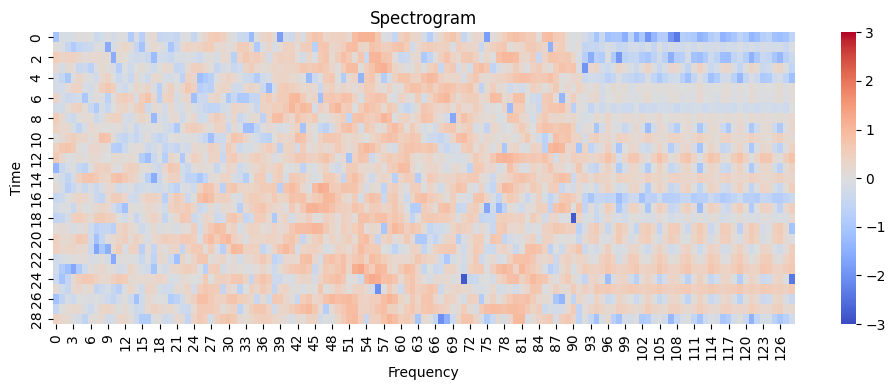

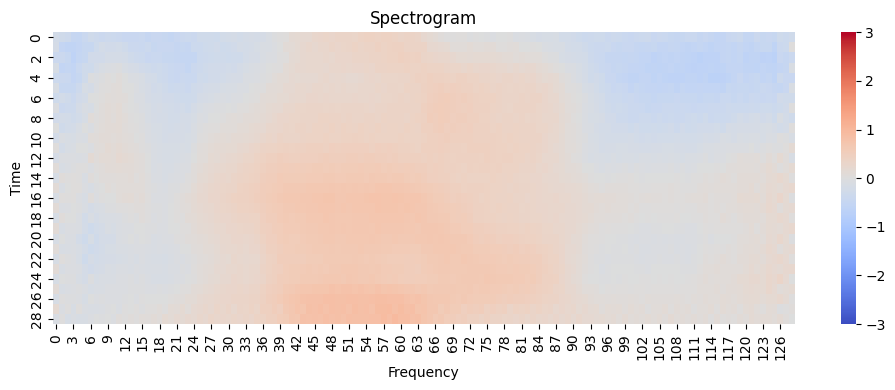

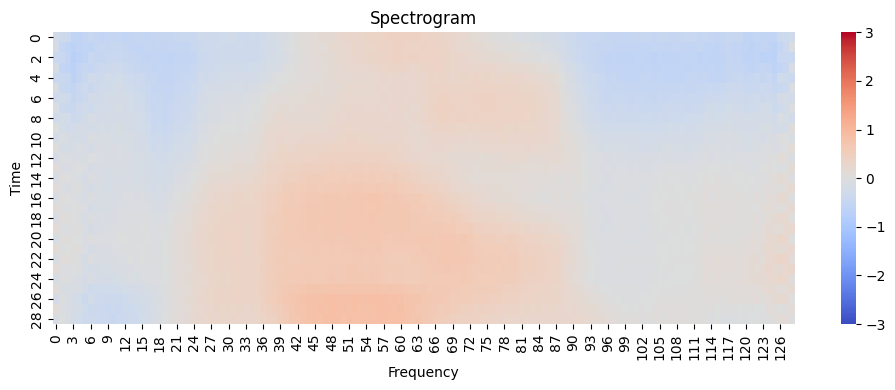

  0%|          | 0/832 [00:03<?, ?it/s]


In [89]:

for i in range(len(loader.checkpoints)):

    # Disabilita il calcolo del gradiente
    with torch.no_grad():
        # Aggiungi tqdm per mostrare il progresso
        
        for inputs, labels in tqdm(test_loader):
            indici = np.argwhere(labels.squeeze() == 2) # 0 per la classe awake, 1 per la classe N1 ecc
            indices_list = indici.tolist()[0] 
            if(len(indices_list) > 15):
                #print(indices_list)
                #print(labels.squeeze())
                # Calcola le previsioni del modello
                index = indices_list[3]
                print(sleep_stages[labels[index][0].item()]) #0 perchè prendo la prima epoca
                
                input_hat = model(inputs.to(device))
                input_hat2 = model2(inputs.to(device))
                x_smoothed = apply_smoothing(inputs)[index][0][0]
                
                # print("inputs:", inputs.size())
                # print("x_smoothed:", x_smoothed.size())
                # print("input_hat:", input_hat.size())

                x = inputs[index][0][0] #0 perchè prendo la prima epoca e il secondo 0 è per prendere il primo canale
                # max = x.max()
                # min = x.min()
                max = 3
                min = -3

                x_hat = input_hat[index].to("cpu")[0][0] #0 perchè prendo la prima epoca e il secondo 0 è per prendere il primo canale 
                max_ = x_hat.max()
                min_ = x_hat.min()

                #print("shape x: ", x.shape)
                plotTheSpectrogram(x, max, min)
                
                # print("shape x_smoothed: ", x_smoothed.shape)
                # plotTheSpectrogram(x_smoothed, max, min)
                
                
                #print("shape x_hat: ", x_hat.shape)
                plotTheSpectrogram(x_hat, max, min)

                x_hat2 = input_hat2[index].to("cpu")[0][0] #0 perchè prendo la prima epoca e il secondo 0 è per prendere il primo canale
                #print("shape x_hat2: ", x_hat2.shape)
                plotTheSpectrogram(x_hat2, max, min)
                break


In [6]:
import torch
import torch.nn as nn

a = torch.tensor([[10, 0, 5], [0, 0, -20]], dtype=torch.float32)
b = torch.tensor([[10, 0, 5], [0, 0, -20], [0, 0, -20], [0, 0, -20]], dtype=torch.float32)

ln = nn.LayerNorm((3))

a_ = ln(a)
b_ = ln(b)

print(a_)
print(b_)

tensor([[ 1.2247, -1.2247,  0.0000],
        [ 0.7071,  0.7071, -1.4142]], grad_fn=<NativeLayerNormBackward0>)
tensor([[ 1.2247, -1.2247,  0.0000],
        [ 0.7071,  0.7071, -1.4142],
        [ 0.7071,  0.7071, -1.4142],
        [ 0.7071,  0.7071, -1.4142]], grad_fn=<NativeLayerNormBackward0>)


## Extracting Loss Function Values


In [13]:

import csv

def extract_column(csv_file, column_name):
    values = []
    steps = []
    with open(csv_file, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row[column_name]:  # Check if the value in the specified column is not empty
                value = (round(float(row[column_name]), 3))
                epoch = int(row['epoch'])
                values.append((epoch, value))
    return values

# Example usage:
versions = [0,1,2,3,4,5,6,7,8,9]
column_name = 'val_loss_target'
model = 'binary_mod1_c8'
column_values_matrix = []
for ver in versions:
    csv_file = 'lightning_logs/' + model + '/version_'+ str(ver) +'/metrics.csv'
    column_values = extract_column(csv_file, column_name)
    print("(" + ")(".join([f"{epoch},{value}" for epoch, value in column_values]) + ")")
    column_values_matrix.append(column_values)

num_columns = len(column_values_matrix[0])
column_sums = [0] * num_columns
for row in column_values_matrix:
    for col_idx, (_, value) in enumerate(row):
        column_sums[col_idx] += value
column_means = [(constant[0], round(sum / len(column_values_matrix),3)) for constant, sum in zip(column_values_matrix[0][0:num_columns], column_sums)]

output = "(" + ")(".join([f"{epoch},{value}" for epoch, value in column_means]) + ")"
print("\n" +output)

FileNotFoundError: [Errno 2] No such file or directory: 'lightning_logs/binary_mod1_c8/version_0/metrics.csv'

In [ ]:
ckp_path = "models/ae"

loader = PhysioLoader(
    #model_name=model,
    #loss_name=loss,
    ckp_path=ckp_path,
    dataset_name=dataset["name"],
    version=dataset["version"],
    use_cache=True,
    sequence_lenght=seqlen,
    batch_size=batch_size,
)

acc = []
acc_concept = []

cm = []
cm_concept = []

reports = []
reports_concept = []

for i in range(len(loader.checkpoints)):
    model, _, _, test_loader = loader.get_fold(i)
    y_pred = []
    y_true = []
    act_pred = []
    act_true = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Imposta il modello in modalità di valutazione
    model = model.eval().to(device)

    outputs = []
    activations = []
    # Disabilita il calcolo del gradiente
    with torch.no_grad():
        # Aggiungi tqdm per mostrare il progresso
        
        for inputs, labels in tqdm(test_loader):
            # Calcola le previsioni del modello
            print(inputs.shape)
            break
            concepts, bo = model.encode(inputs.to(device))
            emb, act = concepts
            activations.extend(act.cpu().detach().squeeze())

            outputs.extend(model(inputs.to(device)).cpu().detach())
            y_true.extend(labels.cpu().detach())
            act_true.extend(labels.cpu().detach())

    outputs = torch.stack(outputs)
    activations = torch.stack(activations)

    y_true = torch.stack(y_true)
    act_true = torch.stack(act_true)

    y_pred = torch.argmax(outputs, dim=len(outputs.size()) - 1)
    act_pred = torch.argmax(activations, dim=len(activations.size()) - 1)

    if len(y_pred.size()) == 2:
        y_pred = y_pred.reshape(-1)
        y_true = y_true.reshape(-1)
        act_pred = act_pred.reshape(-1)
        act_true = act_true.reshape(-1)

    y_true = y_true.numpy()
    act_true = act_true.numpy()
    y_pred = y_pred.numpy()
    act_pred = act_pred.numpy()

    #temp, finchè non ci sono le attivazioni vere
    if(model.n_classes == 2):
        #mette al posto di 2,3,4 il valore 1
        y_true[(y_true == 2) | (y_true == 3) | (y_true == 4)] = 1
        labels_idx = np.arange(2).astype(int)
    else:
        y_true = y_true
        
    print(y_true.shape, y_pred.shape, act_true.shape, act_pred.shape)

    acc.append(accuracy_score(y_true, y_pred))
    acc_concept.append(accuracy_score(act_true, act_pred))
    cm.append(confusion_matrix(y_true, y_pred, labels=labels_idx))
    cm_concept.append(confusion_matrix(act_true, act_pred, labels=labels_idx_concept))

    reports.append(classification_report(y_true, y_pred))
    reports_concept.append(classification_report(act_true, act_pred))

acc = np.array(acc)
cm = np.array(cm)

acc_concept = np.array(acc_concept)
cm_concept = np.array(cm_concept)

print(f"Accuracy: {acc.mean() * 100:.2f}% +/- {acc.std() * 100:.2f}%")
print(f"Accuracy concept: {acc_concept.mean() * 100:.2f}% +/- {acc_concept.std() * 100:.2f}%")

cm_mean = cm.mean(axis=0)
cm_mean = cm_mean.astype("float") / cm_mean.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
#plt.figure(figsize=(3.5, 3))
sns.heatmap(
    cm_mean,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    #xticklabels = ["Awake", "Sleep"],
    #yticklabels =  ["Awake", "Sleep"],
    xticklabels=sleep_stages,
    yticklabels=sleep_stages,
)
plt.title("Normalized Target Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

cm_concept_mean = cm_concept.mean(axis=0)
cm_concept_mean = cm_concept_mean.astype("float") / cm_concept_mean.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_concept_mean,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=sleep_stages,
    yticklabels=sleep_stages,
)
plt.title("Normalized Concept Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()




## Plotting the validation loss

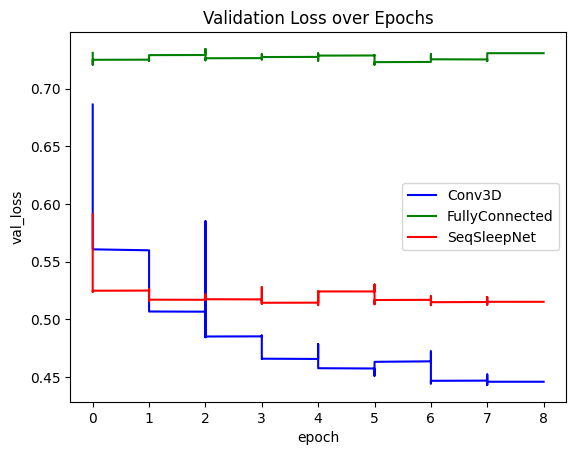

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_val_loss_from_csv(files, label):
    colors = ['b', 'g', 'r']  # Define colors for the plots
    for i, file in enumerate(files):
        # Read the CSV file
        df = pd.read_csv(file)
        
        # Extract 'Epoch' and 'Val_loss' columns
        epochs = df['epoch']
        val_loss = df['val_loss']
        
        # Handle missing values by interpolating
        val_loss = val_loss.interpolate()
        
        # Plot the values
        plt.plot(epochs, val_loss, color=colors[i], label=label[i])

    # Add labels and title
    plt.xlabel('epoch')
    plt.ylabel('val_loss')
    plt.title('Validation Loss over Epochs')
    plt.legend()
    #plt.grid(True)
    plt.show()

# List of CSV files
files = ['physioex/lightning_logs/ae_conv3d/seqlen=3/merged/EEG/version_1/metrics.csv',
         'physioex/lightning_logs/ae_fullyconnected/seqlen=3/merged/EEG/version_1/metrics.csv',
         'physioex/lightning_logs/ae_seqsleepnet/seqlen=3/merged/EEG/version_1/metrics.csv'
         ]

# Call the function to plot the data
plot_val_loss_from_csv(files, ['Conv3D', 'FullyConnected', 'SeqSleepNet'])